# Loading the data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras

data = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

Using TensorFlow backend.


# Preprocessing

In [2]:

# Creating 'Family' feature by adding up 'SibSp' and 'Parch'
data['Family'] = data['SibSp'] + data['Parch']
test['Family'] = test['SibSp'] + test['Parch']

# Creating 'Alone' (<=> 'Family' == 0)
data['Alone'] = np.where(data['Family'] != 0, 0, 1)
test['Alone'] = np.where(test['Family'] != 0, 0, 1)

# Changing Sex to binary (Male = 0 and Female = 1)
data['Sex'] = np.where(data['Sex'] == 'male', 0, 1)
test['Sex'] = np.where(test['Sex'] == 'male', 0, 1)

# Changing Embarked to categorical (C = 1, Q = 2 and S = 3)
data['Embarked'] = data.Embarked.replace(np.NaN, 'Q')
test['Embarked'] = test.Embarked.replace(np.NaN, 'Q')

embarked_dict = {'C': 1, 'Q' : 2, 'S' : 3}
data['Embarked'] = data['Embarked'].apply(lambda x: embarked_dict[x])
test['Embarked'] = test['Embarked'].apply(lambda x: embarked_dict[x])

# Dropping features
data.drop("Ticket",axis = 1, inplace = True) 
data.drop("Name",axis = 1, inplace = True) 
data.drop("Cabin",axis = 1, inplace = True) 
data.drop("PassengerId",axis = 1, inplace = True) 
data.drop("SibSp",axis = 1, inplace = True) 
data.drop("Parch",axis = 1, inplace = True) 

test.drop("Ticket",axis = 1, inplace = True)
test.drop("Name",axis = 1, inplace = True) 
test.drop("Cabin",axis = 1, inplace = True) 
test.drop("SibSp",axis = 1, inplace = True) 
test.drop("Parch",axis = 1, inplace = True) 



# Replacing missing data
def replace_age(df):
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()

    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list


replace_age(data)

test_df = test.copy()
replace_age(test_df)

test.drop("PassengerId",axis = 1, inplace = True) 
test.fillna(test.mean(), inplace=True)

# Spliting training data into features/labels 
x_train, y_train = data.loc[:,data.columns != 'Survived'], data.loc[:,'Survived']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Exploring the data

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
Fare        891 non-null float64
Embarked    891 non-null int64
Family      891 non-null int64
Alone       891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [4]:
data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Alone
0,0,3,0,22.0,7.2500,3,1,0
1,1,1,1,38.0,71.2833,1,1,0
2,1,3,1,26.0,7.9250,3,0,1
3,1,1,1,35.0,53.1000,3,1,0
4,0,3,0,35.0,8.0500,3,0,1
5,0,3,0,38.0,8.4583,2,0,1
6,0,1,0,54.0,51.8625,3,0,1
7,0,3,0,2.0,21.0750,3,4,0
8,1,3,1,27.0,11.1333,3,2,0
9,1,2,1,14.0,30.0708,1,1,0


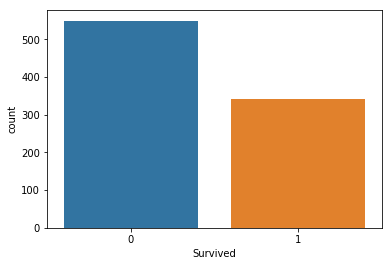

In [5]:
sns.countplot(x="Survived", data=data)

Data is a bit skewed but not significatively

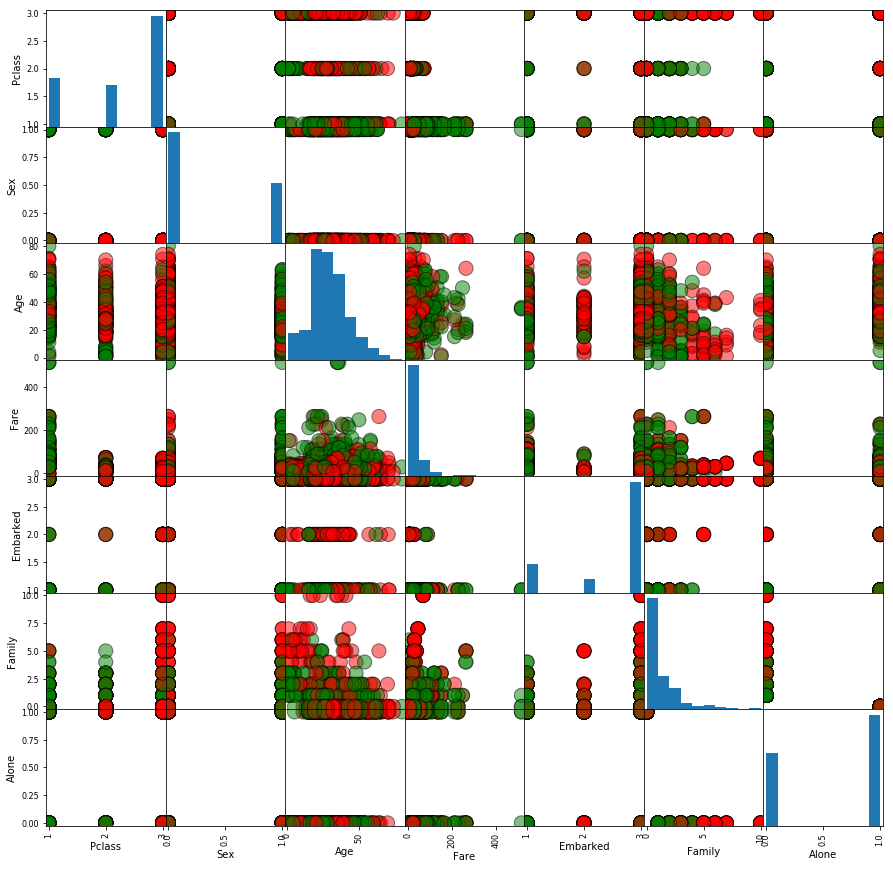

In [34]:
colors = ['red' if i==0 else 'green' for i in data.loc[:,'Survived']]
pd.plotting.scatter_matrix(data.loc[:, ~data.columns.isin(['Survived','Name','Cabin','Parch','SibSp','PassengerId'])],
                                       c=colors,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = 'o',
                                       edgecolor= "black")
plt.show()

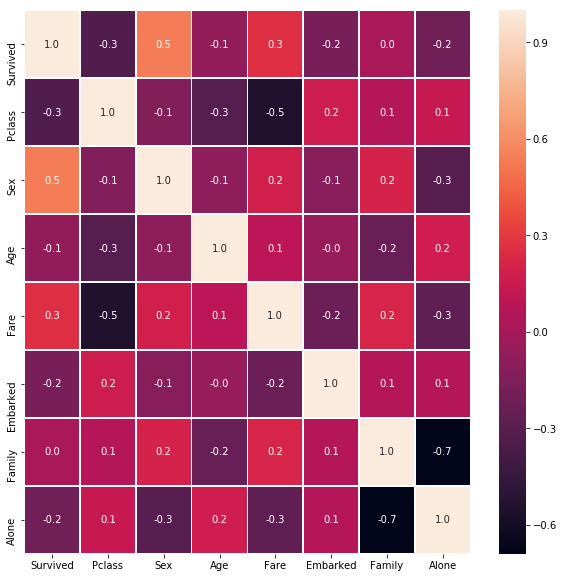

In [36]:
#correlation map
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

We can see some correlation between age, fare, pclass (fare and pclass are naturaly more correlated), sex F and survival (older people might be more upper class, and upper class might be more likely to survive. Females more likely to survive too)

In [8]:
data.describe()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.542278,32.204208,2.534231,0.904602,0.602694
std,0.486592,0.836071,0.477990,13.499214,49.693429,0.791603,1.613459,0.489615
min,0.000000,1.000000,0.000000,0.420000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,7.910400,2.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,14.454200,3.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,37.000000,31.000000,3.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,3.000000,10.000000,1.000000


In [9]:
print 'Covariance between Sex and Survived: {}'.format(data.Survived.cov(data.Sex))

Covariance between Sex and Survived: 0.126376120758


In [10]:
statistic, p_value = stats.ttest_rel(data.Sex,data.Survived)
print 'p-value: {}' .format(p_value) 

p-value: 0.0421557771065


A small p-value (≤ 0.05), which indicates strong evidence against the null hypothesis (Cannot determing survival from Sex)

In [11]:
statistic, p_value = stats.ttest_rel(data.Pclass,data.Survived)
print 'p-value: {}' .format(p_value) 

p-value: 3.84576863711e-273


A small p-value (≤ 0.05), which indicates strong evidence against the null hypothesis (Cannot determing survival from Class)

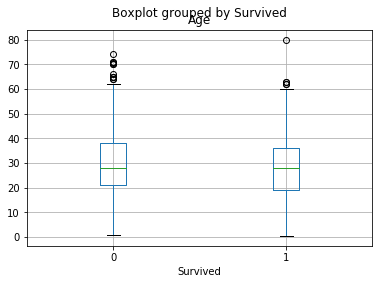

In [12]:
data.boxplot(column='Age',by = 'Survived')

Text(0.5,1,'Age/Fare Scatter Plot')

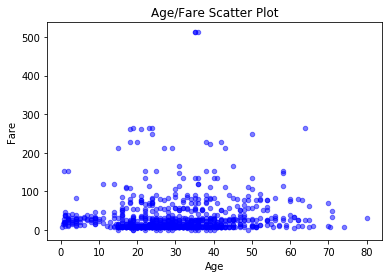

In [13]:
# Scatter Plot 
data.plot(kind='scatter', x='Age', y='Fare',alpha = 0.5,color = 'blue')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age/Fare Scatter Plot')

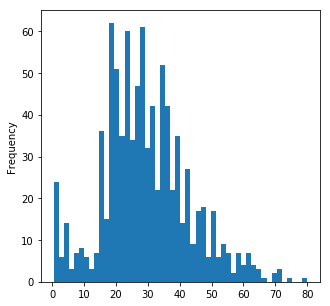

In [14]:
# Age Histogram
data.Age.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

In [15]:
# Sex/Survival
data.groupby(['Sex','Survived']).size()

Sex  Survived
0    0           468
     1           109
1    0            81
     1           233
dtype: int64

In [16]:
# Pclass/Survival
data.groupby(['Pclass','Survived']).size()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

In [17]:
data[data['Survived']==1].Survived.count()

342

In [18]:
data[(data['Age']<18) & (data['Survived']==1)].Survived.count()

67

In [19]:
data[(data['Sex']==1) & (data['Survived']==1)].Survived.count()

233

In [20]:
data[(data['Sex']==0) & (data['Survived']==1)].Survived.count()

109

## Machine learning
After having explored the data, we will no try to fit some ML models in order to get predictions on the test set.

In [21]:
_CV = 4

### Logistic Regression

In [22]:
# pipline normalizing data then calling Logistic Regression classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('LOGIT', LogisticRegression())])

# List of Logistic Regression parameters
params = {'LOGIT__C':[0.01, 0.1, 1, 10, 100, 1000]}

# Grid searching the parameters to find the best combination
logit = GridSearchCV(pipeline,param_grid=params,cv=_CV)
logit.fit(x_train,y_train)

print("Accuracy: {}".format(logit.best_score_))
print("Best parameters: {}".format(logit.best_params_))

Accuracy: 0.792368125701
Best parameters: {'LOGIT__C': 1}


### KNN

In [23]:
# pipline normalizing data then calling K-Nearest Neighbors classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('KNN', KNeighborsClassifier())])

# List of KNN parameters
params = {'KNN__n_neighbors': np.arange(1, 20)}

# Grid searching the parameters to find the best combination
knn = GridSearchCV(pipeline,param_grid=params,cv=_CV)
knn.fit(x_train,y_train)

print("Accuracy: {}".format(knn.best_score_))
print("Best parameters: {}".format(knn.best_params_))

Accuracy: 0.81593714927
Best parameters: {'KNN__n_neighbors': 14}


### SVM

In [24]:
# pipline normalizing data then calling SVM classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('SVM', SVC())])

# List of SVM parameters
params = {'SVM__C':[1, 10, 100, 1000],
              'SVM__gamma':[0.1, 0.01, 0.001]}

# Grid searching the parameters to find the best combination
svm = GridSearchCV(pipeline,param_grid=params,cv=_CV)
svm.fit(x_train,y_train)

print("Accuracy: {}".format(svm.best_score_))
print("Best parameters: {}".format(svm.best_params_))

Accuracy: 0.828282828283
Best parameters: {'SVM__C': 1, 'SVM__gamma': 0.1}


### Random Forest

In [25]:
# pipline normalizing data then calling Random Forest classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('RF', RandomForestClassifier())])

# List of RF parameters
params = {'RF__n_estimators':[10, 100, 200, 300],
              'RF__max_depth':[2, 3, 5, 7, 8]}

# Grid searching the parameters to find the best combination
rf = GridSearchCV(pipeline,param_grid=params,cv=_CV)
rf.fit(x_train,y_train)

print("Accuracy: {}".format(rf.best_score_))
print("Best parameters: {}".format(rf.best_params_))

Accuracy: 0.824915824916
Best parameters: {'RF__max_depth': 8, 'RF__n_estimators': 300}


### Deep Neural Network
(DNNs are not the best option when the data set is this small, but lets do it anyway!)

#### Using Keras

In [26]:
X, x_test, Y, y_test = train_test_split(x_train,y_train,test_size=0.25,random_state=None)

#Creating the DNN
dnn = Sequential()
dnn.add(Dense(150, input_dim=7, activation='sigmoid'))
dnn.add(Dense(150, activation='relu'))
dnn.add(Dense(150, activation='relu'))
dnn.add(Dropout(0.5))
dnn.add(Dense(1, activation='sigmoid'))
dnn.compile(loss='binary_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 46,651
Trainable params: 46,651
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Fitting the model
history = dnn.fit(x_train,y_train ,validation_split=0.3, epochs=80, verbose=1)

Train on 623 samples, validate on 268 samples
Epoch 1/80
623/623 [==============================] - 0s 616us/step - loss: 0.6548 - acc: 0.6356 - val_loss: 0.6006 - val_acc: 0.6679
Epoch 2/80
623/623 [==============================] - 0s 67us/step - loss: 0.6527 - acc: 0.6661 - val_loss: 0.5915 - val_acc: 0.7164
Epoch 3/80
623/623 [==============================] - 0s 69us/step - loss: 0.6387 - acc: 0.6517 - val_loss: 0.6216 - val_acc: 0.7127
Epoch 4/80
623/623 [==============================] - 0s 75us/step - loss: 0.6357 - acc: 0.6661 - val_loss: 0.6271 - val_acc: 0.7015
Epoch 5/80
623/623 [==============================] - 0s 78us/step - loss: 0.6159 - acc: 0.6790 - val_loss: 0.5731 - val_acc: 0.7313
Epoch 6/80
623/623 [==============================] - 0s 75us/step - loss: 0.6251 - acc: 0.6661 - val_loss: 0.5576 - val_acc: 0.7351
Epoch 7/80
623/623 [==============================] - 0s 71us/step - loss: 0.6217 - acc: 0.6709 - val_loss: 0.5431 - val_acc: 0.7239
Epoch 8/80
623/623 [==

Epoch 62/80
623/623 [==============================] - 0s 60us/step - loss: 0.4415 - acc: 0.8074 - val_loss: 0.3725 - val_acc: 0.8284
Epoch 63/80
623/623 [==============================] - 0s 56us/step - loss: 0.4462 - acc: 0.8042 - val_loss: 0.4223 - val_acc: 0.8134
Epoch 64/80
623/623 [==============================] - 0s 60us/step - loss: 0.4550 - acc: 0.8106 - val_loss: 0.4364 - val_acc: 0.7910
Epoch 65/80
623/623 [==============================] - 0s 57us/step - loss: 0.4408 - acc: 0.8138 - val_loss: 0.3838 - val_acc: 0.8321
Epoch 66/80
623/623 [==============================] - 0s 58us/step - loss: 0.4336 - acc: 0.8186 - val_loss: 0.4063 - val_acc: 0.8172
Epoch 67/80
623/623 [==============================] - 0s 56us/step - loss: 0.4431 - acc: 0.8042 - val_loss: 0.3899 - val_acc: 0.8209
Epoch 68/80
623/623 [==============================] - 0s 56us/step - loss: 0.4283 - acc: 0.8250 - val_loss: 0.3667 - val_acc: 0.8284
Epoch 69/80
623/623 [==============================] - 0s 60us

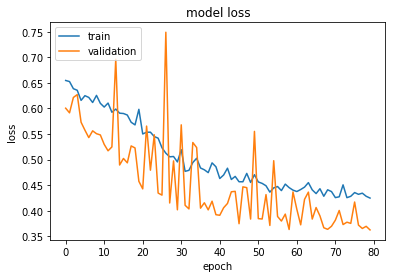

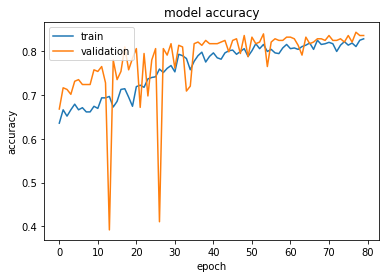

223/223 [==============================] - 0s 30us/step


[0.38395754652173, 0.8385650189468145]

In [28]:
def plot_hist(history):
    #Ploting Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    #Plotting Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
# Ploting History
plot_hist(history)

# Evalulating
dnn.evaluate(x_test,y_test)

#### Using Scikit-learn's MLPClassifier

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline([('scalar', StandardScaler()),
         ('MLP', MLPClassifier(hidden_layer_sizes=(150,150,150,), max_iter=80, alpha=1e-4,
                    solver='adam', verbose=0))])

mlp.fit(X,Y)

print("Accuracy: {}".format(mlp.score(x_test, y_test)))


Accuracy: 0.829596412556


### Ensemble Learning 
In this part, we will try to combine all of our previous models into an ensemble model that should, theoretically, be better at predecting

In [30]:
from sklearn.ensemble import VotingClassifier

logit = Pipeline([('scalar', StandardScaler()),
         ('LOGIT', LogisticRegression(C=1))])

knn = Pipeline([('scaler', StandardScaler()),
         ('KNN', KNeighborsClassifier(n_neighbors=14))])

svm = Pipeline([('scalar', StandardScaler()),
         ('SVM', SVC(C=1000,gamma=0.01))])

rf = Pipeline([('scalar', StandardScaler()),
         ('RF', RandomForestClassifier(max_depth=7, n_estimators=100))])

mlp = Pipeline([('scalar', StandardScaler()),
         ('MLP', MLPClassifier(hidden_layer_sizes=(150,150,150,), max_iter=80, alpha=1e-4,
                    solver='adam', verbose=0))])

voting = VotingClassifier(
    estimators=[('svm', svm), ('rf', rf),('mlp', mlp)], 
    voting='hard')


voting = voting.fit(x_train,y_train)



In [31]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": voting.predict(test)
    })

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [32]:
submission.to_csv('./submission.csv', index=False)